<a href="https://colab.research.google.com/github/JoeyBarlia/Drilling-Failure-Analysis/blob/main/Technical_Modeling_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Technical Modeling

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import RandomOverSampler

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.backend import clear_session


We will now turn our attention back to machine failures and trying to predict them.

In [13]:
df = pd.read_csv('XAI_Drilling_Dataset.csv')
df.head()

,ID,Cutting speed vc [m/min],Spindle speed n [1/min],Feed f [mm/rev],Feed rate vf [mm/min],Power Pc [kW],Cooling [%],Material,Drill Bit Type,Process Time [sec],Main Failure,BEF,CCF,FWF,WDF
0,1,29.92,794,0.218,173,194.87,75,N,W,19.26,0,0,0,0,0
1,2,29.85,792,0.241,191,214.71,75,N,W,19.55,0,0,0,0,0
2,3,22.85,606,0.183,111,95.68,50,P,N,36.16,0,0,0,0,0
3,4,29.60,785,0.236,237,206.93,75,N,W,21.22,1,0,0,1,0
4,5,17.43,462,0.246,114,74.85,50,K,H,33.56,0,0,0,0,0


In [14]:
#Drop ID since it has no predictive power.
df.drop(['ID'],axis=1,inplace=True)

#Drop the failure types, as we're only interested whether a machine fails
df.drop(['BEF','CCF','FWF','WDF'],axis=1,inplace=True)

In [15]:
# convert Drill Bit Type attribute into numbers, so that W = 0, H = 1, and N = 2
df['Drill Bit Type'].replace('W', 0, inplace=True)
df['Drill Bit Type'].replace('H', 1, inplace=True)
df['Drill Bit Type'].replace('N', 2, inplace=True)

# convert Material attribute into numbers, so that  P= 0, K = 1, and N = 2
df['Material'].replace('P', 0, inplace=True)
df['Material'].replace('K', 1, inplace=True)
df['Material'].replace('N', 2, inplace=True)

<ipython-input-15-9ad3ae710698>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Drill Bit Type'].replace('W', 0, inplace=True)
<ipython-input-15-9ad3ae710698>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

In [16]:
#select target
X = df.drop(['Main Failure'], axis=1)
y = df['Main Failure']

#split into training and tesing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Since the data is imblanced, we oversample the training data.  

In [17]:
#tried both oversampling techniques. SMOTE performed slightly better

oversample = SVMSMOTE(random_state = 42)
#oversample = RandomOverSampler(random_state=42)

X_train, y_train = oversample.fit_resample(X_train, y_train)

In [18]:
# scaling did not improve performance of any classical ML model. Only the ANN

sc = MinMaxScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

####Decision Tree

In [21]:
dt_model = DecisionTreeClassifier(criterion='gini', max_depth=None, random_state=42)
dt_model.fit(X_train, y_train)

y_train_pred_dt = dt_model.predict(X_train)
y_test_pred_dt = dt_model.predict(X_test)

# Train and Test Accuracy
train_accuracy_dt = accuracy_score(y_train, y_train_pred_dt)
test_accuracy_dt = accuracy_score(y_test, y_test_pred_dt)

# Confusion Matrix
cm_dt = confusion_matrix(y_test, y_test_pred_dt)

print("Decision Tree Classifier")
print(f"Training Accuracy: {train_accuracy_dt:.4f}")
print(f"Testing Accuracy: {test_accuracy_dt:.4f}")
print("Confusion Matrix:")
print(cm_dt)

print("Classification Report:\n", classification_report(y_test, y_test_pred_dt))

Decision Tree Classifier
Training Accuracy: 1.0000
Testing Accuracy: 0.9955
Confusion Matrix:
[[5661   19]
 [   8  312]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5680
           1       0.94      0.97      0.96       320

    accuracy                           1.00      6000
   macro avg       0.97      0.99      0.98      6000
weighted avg       1.00      1.00      1.00      6000



###KNN

In [22]:
knn_model = KNeighborsClassifier(n_neighbors=5,)
knn_model.fit(X_train, y_train)

y_train_pred_knn = knn_model.predict(X_train)
y_test_pred_knn = knn_model.predict(X_test)

train_accuracy_knn = accuracy_score(y_train, y_train_pred_knn)
test_accuracy_knn = accuracy_score(y_test, y_test_pred_knn)

cm_knn = confusion_matrix(y_test, y_test_pred_knn)

print("\nK-Nearest Neighbors Classifier")
print(f"Training Accuracy: {train_accuracy_knn:.4f}")
print(f"Testing Accuracy: {test_accuracy_knn:.4f}")
print("Confusion Matrix:")
print(cm_knn)

print("Classification Report:\n", classification_report(y_test, y_test_pred_knn))


K-Nearest Neighbors Classifier
Training Accuracy: 0.9926
Testing Accuracy: 0.9773
Confusion Matrix:
[[5621   59]
 [  77  243]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      5680
           1       0.80      0.76      0.78       320

    accuracy                           0.98      6000
   macro avg       0.90      0.87      0.88      6000
weighted avg       0.98      0.98      0.98      6000



###Random Forest

In [23]:
rfc = RandomForestClassifier(n_estimators=20, max_depth=10, min_samples_split=10,
                             min_samples_leaf=4, random_state=42)
rfc.fit(X_train, y_train)

y_train_pred_rfc = rfc.predict(X_train)
y_test_pred_rfc = rfc.predict(X_test)

train_accuracy_rfc = accuracy_score(y_train, y_train_pred_rfc)
test_accuracy_rfc = accuracy_score(y_test, y_test_pred_rfc)

cm_rfc = confusion_matrix(y_test, y_test_pred_rfc)

print("Random Forest Classifier")
print(f"Training Accuracy: {train_accuracy_rfc:.4f}")
print(f"Testing Accuracy: {test_accuracy_rfc:.4f}")
print("Confusion Matrix:")
print(cm_rfc)

print("Classification Report:\n", classification_report(y_test, y_test_pred_rfc))

Random Forest Classifier
Training Accuracy: 0.9934
Testing Accuracy: 0.9970
Confusion Matrix:
[[5669   11]
 [   7  313]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5680
           1       0.97      0.98      0.97       320

    accuracy                           1.00      6000
   macro avg       0.98      0.99      0.99      6000
weighted avg       1.00      1.00      1.00      6000



Random forest performed the best. We will do a gridsearch

In [24]:
param_grid = {
    'n_estimators': [20, 40, 60],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)


Fitting 5 folds for each of 81 candidates, totalling 405 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 20}


Retrain with best parameters

In [25]:
best_params = grid_search.best_params_

rfc_best = RandomForestClassifier(**best_params, random_state=42)
rfc_best.fit(X_train, y_train)

y_train_pred_best_rfc = rfc_best.predict(X_train)
y_test_pred_best_rfc = rfc_best.predict(X_test)

train_accuracy_best_rfc = accuracy_score(y_train, y_train_pred_best_rfc)
test_accuracy_best_rfc = accuracy_score(y_test, y_test_pred_best_rfc)

cm_best_rfc = confusion_matrix(y_test, y_test_pred_best_rfc)

print("'Best' Random Forest Classifier")
print(f"Training Accuracy: {train_accuracy_best_rfc:.4f}")
print(f"Testing Accuracy: {test_accuracy_best_rfc:.4f}")
print("Confusion Matrix:")
print(cm_best_rfc)

print("Classification Report:\n", classification_report(y_test, y_test_pred_best_rfc))


'Best' Random Forest Classifier
Training Accuracy: 0.9999
Testing Accuracy: 0.9968
Confusion Matrix:
[[5670   10]
 [   9  311]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5680
           1       0.97      0.97      0.97       320

    accuracy                           1.00      6000
   macro avg       0.98      0.99      0.98      6000
weighted avg       1.00      1.00      1.00      6000



The random forest was already performing so well that there was not much more we could improve.

##ANN

In [64]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(9,)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,753 (10.75 KB)

 Trainable params: 2,753 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

In [65]:
Maintenance = model.fit(X_train_scaled, y_train, epochs=45, verbose=True, validation_split=0.3, batch_size=50)

Epoch 1/45
373/373 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7496 - loss: 0.5076 - val_accuracy: 0.6595 - val_loss: 0.6516
Epoch 2/45
373/373 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9049 - loss: 0.2420 - val_accuracy: 0.9479 - val_loss: 0.3204
Epoch 3/45
373/373 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9395 - loss: 0.1764 - val_accuracy: 0.8009 - val_loss: 0.3679
Epoch 4/45
373/373 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9416 - loss: 0.1555 - val_accuracy: 0.9174 - val_loss: 0.2674
Epoch 5/45
373/373 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9417 - loss: 0.1439 - val_accuracy: 0.9648 - val_loss: 0.1359
Epoch 6/45
373/373 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9472 - loss: 0.1380 - val_accuracy: 0.9374 - val_loss: 0.2466
Epoch 7/45
373/373 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9497 - loss: 0.1303 - val_accuracy: 0.9703 - val_loss: 0.1171
Epoch 8/45
373/373 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9544 - loss: 0.1197 - val_accuracy: 0.

In [66]:
#plot for training and validation accuracy/loss
def plot_history(Maintenance):
    acc = Maintenance.history['accuracy']
    val_acc = Maintenance.history['val_accuracy']
    loss = Maintenance.history['loss']
    val_loss = Maintenance.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, label='Training acc')
    plt.plot(x, val_acc, label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, label='Training loss')
    plt.plot(x, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()


Training Accuracy: 0.9842
Testing Accuracy:  0.9935


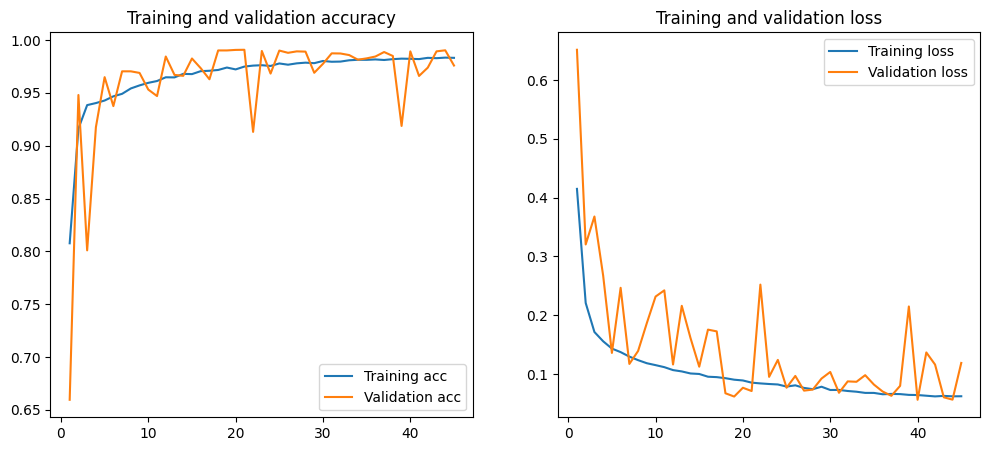

In [67]:
loss, accuracy = model.evaluate(X_train_scaled, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_history(Maintenance)

Lets try a few different things to see if we can improve the performance just a little more.

In [68]:
clear_session()

In [69]:
#fewer neurons, fewer layers, and different activation function
model_2 = Sequential([
    Dense(32, activation='tanh', input_shape=(9,)),
    Dense(1, activation='sigmoid')
])
model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 353 (1.38 KB)

 Trainable params: 353 (1.38 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
Maintenance = model_2.fit(X_train_scaled, y_train, epochs=45, verbose=True, validation_split=0.3, batch_size=50)

Epoch 1/45
373/373 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6475 - loss: 0.6363 - val_accuracy: 0.0000e+00 - val_loss: 1.1926
Epoch 2/45
373/373 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7168 - loss: 0.5567 - val_accuracy: 0.1753 - val_loss: 1.0906
Epoch 3/45
373/373 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7460 - loss: 0.5286 - val_accuracy: 0.2370 - val_loss: 1.0042
Epoch 4/45
373/373 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7678 - loss: 0.4922 - val_accuracy: 0.2869 - val_loss: 0.8295
Epoch 5/45
373/373 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7939 - loss: 0.4579 - val_accuracy: 0.3006 - val_loss: 0.9276
Epoch 6/45
373/373 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8204 - loss: 0.4132 - val_accuracy: 0.4994 - val_loss: 0.7931
Epoch 7/45
373/373 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8436 - loss: 0.3760 - val_accuracy: 0.6221 - val_loss: 0.6382
Epoch 8/45
373/373 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8695 - loss: 0.3480 - val_accuracy

Training Accuracy: 0.9444
Testing Accuracy:  0.9678


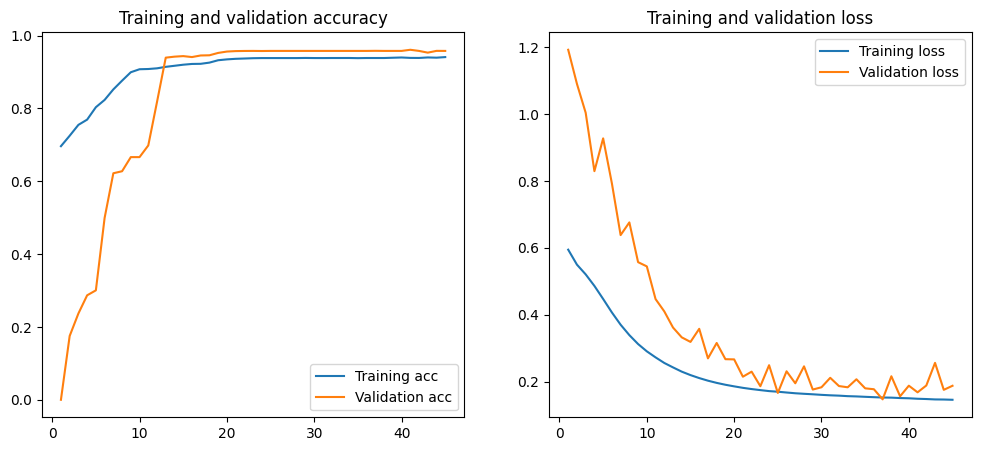

In [71]:
loss, accuracy = model_2.evaluate(X_train_scaled, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_2.evaluate(X_test_scaled, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(Maintenance)

That ANN performed worse. We will stick with the first one.

##Summary

First we ran decision tree, KNN, and random forest. All performed very well but the random forest was the best by a small margin. We ran a gridsearch to see if we could squeeze any last drops of performance out of the random forest but we were unsuccesful. We then built an ANN and got slighly worse performance than the random forrest. We tried a simpler ANN and got even worse performance. This dataset is synthetic and was able to be fit easily by even simple ML models. Real data could present much more noise and complexity that would be able to better showcase the power of deep learning.

In the real world, this model can be used to predict the specific tasks that strain drilling machines, or predict tasks that cause machine failures. This can let technicians know when to take extra measures to prevent machine failures (i.e. lower feed rate, increase cooling).